In [1]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
import threading
import time
import math
import scipy as sp
from datetime import datetime, timedelta

## Group Assignment
### Team Number: 08
### Team Member Names: Richard Meng, Avaansh Nanda, Devesh Kotak
### Team Strategy Chosen: Market Beat




# Overview: #


Our portfolio generating strategy for this project is **market beat**. In other words, how can we have returns that exceed market expectations? We do this by calculating the **Sharpe ratio** and **alpha values** based on the monthly data of our stocks. We then combine those values into a combined score, with a weighting of **70% alpha**, **30% Sharpe ratio**. We have chosen these weightings because alpha measures the return compared to the index average, providing us with the best indication of strong performance. A 30% Sharpe ratio is factored in to account for risk-adjusted returns, as we have developed this portfolio generator with long-term performance in mind. Thus, we have chosen a stronger weighting in alpha because it is more catered towards our goal.

We use this score to rank the stocks. We take the top 25 stocks, loop through the top **10-25** stocks and generate a portfolio with each number of stocks. Then we see which portfolio generates the greatest return and choose that as the number of stocks. Each individual portfolio will be optimized. For example, if we look at a portfolio with 12 stocks, it will be the most optimal portfolio with 12 stocks, found by using scipy to optimize weightings using math.

Overall, our strategy looks at the history of each stock and how well it performed compared to the market and uses this history to predict which stocks will best beat the market in the future. Theoretically, if every stock has a high return over the market, then accumulatively our portfolio will have a higher return over the market.


We first start by reading the CSV file of tickers and processing the tickers as a list for easy iteration.

tickers: list of all tickers imported from the CSV

<h2><font color='red'>
    New Below: 
</font></h2>

<h4><font color='red'> 
    
- Removing leading and trailing whitespace, also converting to uppercase for safety

- Filtering out stocks more by removing cross-listed stocks (e.g SHOP and SHOP.TO) as well as Bitcoin (BITCOIN-USD)
    
</font></h4>


In [2]:
# Read in the csv file and set the header to none, otherwise it will treat the first ticker as the header
tickers_csv = pd.read_csv("Tickers.csv", header=None)
# Clean tickers

# Strip whitespace and uppercase
tickers = [str(t).strip().upper() for t in tickers_csv[0] if pd.notna(t)]

# Remove empty strings 
tickers = [t for t in tickers if t]

# Remove crypto 
tickers = [
    t for t in tickers
    if not (
        "-USD" in t or
        "-CAD" in t or
        "=F" in t # commodity 
    )
]
valid_chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789."

def is_valid(t):
    for ch in t:
        if ch not in valid_chars:
            return False
        return True
    
tickers = [t for t in tickers if is_valid(t)]

# Remove duplicate listings across exchanges (e.g. SHOP vs SHOP.TO)
base_seen = set()
cleaned_tickers = []

for t in tickers:
    base = t.split(".")[0]   # SHOP.TO -> SHOP
    if base not in base_seen:
        base_seen.add(base)
        cleaned_tickers.append(t)

tickers = cleaned_tickers
list(tickers)

['INVALIDTIC',
 'ASDFA.TO',
 'SU.TO',
 'ABBV',
 'LOW',
 'AUST',
 'TD',
 'AMZN',
 'AXP',
 'GCT',
 'BK',
 'HDFC.NS',
 'SQ',
 'CELG',
 'EXE.TO',
 'CMCSA',
 'SHOP',
 'COST',
 'CSCO',
 'GM',
 'GOOG',
 'AIM.TO',
 'FTG.TO',
 'ORCL',
 'SAP.TO',
 'DUOL',
 'PEP',
 'T.TO',
 'SLB',
 'SO',
 'SPG',
 'RY.TO',
 'AW.TO',
 'VSP.TO',
 'XZO']

Below are some functions to help assist downloading our stock data from yfinance. We use daily data to assist with filtering, and use monthly data to analyze the performance of the stocks. The respective functions are below.

Then, we store it as a dictionary to avoid constant calls to yfinance. 

download_yf(ticker_subset, start, end): Takes in some tickers, a start and end date.
- Outputs a dictionary mapping the ticker name to its ticker daily data in the form of a DataFrame.

monthly_download_yf(ticker_subset, start, end): Takes in some tickers, a start and end date.
- Outputs a dictionary mapping the ticker name to its ticker monthly data in the form of a DataFrame.

tickers_data: Dictionary mapping a ticker to its yFinance DataFrame daily data

monthly_tickers_data: Dictionary mapping a ticker to its yFinance DataFrame monthly data



In [3]:
#  We will be filtering 47 tickers. 
START_DATE = "2024-10-01"
END_DATE = "2025-09-30"
tickers_data = {}
monthly_tickers_data = {}

# helper function to download stock data 
def download_yf(ticker_subset, start, end):
    # looping through each ticker and downloading the data from yfinance, and storing in a dict
    for ticker in ticker_subset:
        tickers_data[ticker] = yf.download(ticker, start, end, auto_adjust=False, progress=False)

# helper function to download MONTHLY stock data
def download_monthly_yf(ticker_subset, start, end):
    # looping through each ticker and downloading the data from yfinance, and storing in a dict
    for ticker in ticker_subset:
        monthly_tickers_data[ticker] = yf.download(ticker, start, end, auto_adjust=False, progress=False, interval="1mo")


# stored in a dictionary where each key pair value is the ticker, DataFrame of data
download_yf(tickers, START_DATE, END_DATE)

HTTP Error 404: 

1 Failed download:
['INVALIDTIC']: YFTzMissingError('possibly delisted; no timezone found')
HTTP Error 404: 

1 Failed download:
['ASDFA.TO']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CELG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['XZO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-10-01 -> 2025-09-30) (Yahoo error = "Data doesn\'t exist for startDate = 1727755200, endDate = 1759204800")')


Next, we begin filtering the stocks. We first must check that they are Canadian or American, which can be done by checking their currency. Then we check if the company is actually listed on its respective market. Lastly, we check the daily average volume (excluding months with less than the minimum, 18 trading days) and exclude stocks with less than the minimum daily average volume, 5000.

Threading is used to speed up the process of filtering through tickers, as this may take a long time due to yFinance .info and .fast_info calls.

After all threading is completed, we add each ticker and map the ticker to its data (sector, currency) in a dictionary called ticker_dict. Then we also create a list called valid_tickers to contain only the tickers for easy iteration.

valid_ticker(ticker, results, index): Takes in a ticker, some list to add the ticker to, and an index to associate the ticker with.
- Adds the ticker, sector, and currency of the stock to the list of valid tickers at the index if it is valid, otherwise it will not add it to the list of valid tickers.

filter_ticker(tickers): Wrapper function that uses threading to execute valid_ticker simultaneously.
- Returns a list of valid tickers

ticker_dict: Dictionary that stores a key-value pair ticker: (ticker_sector, ticker_currency)

valid_tickers: List that stores all the valid tickers

In [4]:
# function to check if a singular ticker is valid, then add it to an array of results at its respective index
# this is the helper function for the thread
MIN_TRADING_DAYS = 18
MIN_VOLUME = 5000
VALID_CURRENCIES = ['USD','CAD']

def valid_ticker(ticker, results, index):
    try:
        # Store data so we do not reuse yfTicker methods to improve efficiency
        yfTicker = yf.Ticker(ticker)
        ticker_data = tickers_data[ticker]   
        currency = yfTicker.fast_info.get('currency')
        sector = yfTicker.info.get('sector')

        # Create a copy of ticker_data so we do not override our original dataframe
        df = ticker_data.copy()
        # Creates a column for just the month of the current index
        df["Month"] = df.index.to_period("M")

        # initialize variables
        total_vol = 0
        total_trading_days = 0

        # Loop through all months in the range
        for month in pd.period_range(START_DATE, END_DATE, freq="M"):
            # create a dataframe containing the ticker's data only in one specific month
            month_df = df[df["Month"] == month]

            # the length of the index will give us exactly how many trading days there are
            trading_days = len(month_df.index)

            # if the trading days exceed the minimum number of trading days, count it towards our average
            if trading_days >= MIN_TRADING_DAYS:
                total_vol += month_df["Volume"].sum().iloc[0]
                total_trading_days += trading_days

        # calculate average daily volume
        avg_daily_vol = total_vol / total_trading_days if total_trading_days > 0 else 0

        # if the average daily volume is less than required or the currency is invalid, discard the ticker
        if avg_daily_vol < MIN_VOLUME or currency not in VALID_CURRENCIES:
            results[index] = None
            print(f"removed {ticker}")
        # otherwise, the ticker is valid and keep it
        else:
            results[index] = (ticker, sector, currency)

    # Use an exception to catch delisted stocks
    except Exception as e:
        print(f"{ticker} is delisted {e}")
        results[index] = None


# function for threading to speed up the process
def filter_tickers(tickers):
    # initialize a list to store all our threads and valid_tickers to get the return value of the valid_ticker function
    threads = []
    valid_tickers = [""] * len(tickers)

    # loop through the list of possible tickers and get the index and actual ticker
    for index, ticker in enumerate(tickers):
        # start a thread using the valid_ticker function and pass in its respective arguments
        t = threading.Thread(target=valid_ticker, args=(ticker, valid_tickers, index))
        # start the thread and append it to the threads list
        t.start()
        threads.append(t)

    # loop through each thread and join them
    for thread in threads:
        thread.join()
    # use a list comprehension to add to valid_tickers if the ticker is not None.
    return [v for v in valid_tickers if v]

# store the valid_tickers in a list
valid_tickers = filter_tickers(tickers)
# initalize a dictionary to store elements as ticker : (sector, currency)
ticker_dict = {}
# add all valid tickers to the dictionary
for ticker_tup in valid_tickers:
    ticker_dict[ticker_tup[0]] = ticker_tup[1::]

# then change valid_tickers to a list of only the tickers
valid_tickers = [t[0] for t in valid_tickers]

$ASDFA.TO: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$SQ: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$CELG: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$HDFC.NS: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$INVALIDTIC: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


ASDFA.TO is delisted 'currency'
SQ is delisted 'currency'
CELG is delisted 'currency'
HDFC.NS is delisted 'currency'
INVALIDTIC is delisted 'currency'
removed XZO


Here is the list of all tickers that follow the rules and their respective information stored in a dictionary

In [5]:
print(len(ticker_dict.keys()), len(tickers))
ticker_dict

29 35


{'SU.TO': ('Energy', 'CAD'),
 'ABBV': ('Healthcare', 'USD'),
 'LOW': ('Consumer Cyclical', 'USD'),
 'AUST': ('Basic Materials', 'USD'),
 'TD': ('Financial Services', 'USD'),
 'AMZN': ('Consumer Cyclical', 'USD'),
 'AXP': ('Financial Services', 'USD'),
 'GCT': ('Technology', 'USD'),
 'BK': ('Financial Services', 'USD'),
 'EXE.TO': ('Healthcare', 'CAD'),
 'CMCSA': ('Communication Services', 'USD'),
 'SHOP': ('Technology', 'USD'),
 'COST': ('Consumer Defensive', 'USD'),
 'CSCO': ('Technology', 'USD'),
 'GM': ('Consumer Cyclical', 'USD'),
 'GOOG': ('Communication Services', 'USD'),
 'AIM.TO': ('Basic Materials', 'CAD'),
 'FTG.TO': ('Industrials', 'CAD'),
 'ORCL': ('Technology', 'USD'),
 'SAP.TO': ('Consumer Defensive', 'CAD'),
 'DUOL': ('Technology', 'USD'),
 'PEP': ('Consumer Defensive', 'USD'),
 'T.TO': ('Communication Services', 'CAD'),
 'SLB': ('Energy', 'USD'),
 'SO': ('Utilities', 'USD'),
 'SPG': ('Real Estate', 'USD'),
 'RY.TO': ('Financial Services', 'CAD'),
 'AW.TO': ('Consumer Cy

Since we must choose **10-25 stocks**, we will first rank the top 25 stocks using a metric or scoring system we came up with mentioned earlier.

Each stock has a score: 
* $\ 0.3*Sharpe \ Ratio + 0.7*Alpha $

We chose this metric because the Sharpe Ratio provides the risk-adjusted return, while the Alpha indicates the return above the market. 

We chose the $\ Sharpe \ Ratio$ as we still would like to be slightly risk-averse and it provides us a strong indicator of how much a stock returns given its risk, over a long-term period. As for$\ Alpha$, this helps us with our goal, of market beat, by giving a stock's specific return above the market.

We will find the Sharpe Ratio of each stock by finding the returns of each stock, the risk-free rate given by t-bills (dependent on currency), and the standard deviation of each stock.

Then we will find the Alpha of each stock by finding the returns of each stock and the returns of its respective market (also dependent on currency)

Since we need a small cap (<$\$2$  billion) and a large cap (>$\$10$ billion) we first add the highest scoring large cap and highest scoring small cap as our first stocks.

Then we proceed and add all the other highest scoring stocks in order.

Finally, we output the top 25 stocks in order from highest to lowest and create a score for all the valid stocks.

get_risk_free_rates(): a function that retrieves the Canadian and American risk-free rates
- returns the risk-free rate as a tuple (American, Canadian)

get_sharpe_ratios(tickers): inputs a list of tickers and finds the Sharpe ratio of each
- maps each ticker to its Sharpe ratio using a dictionary and returns the dictionary

get_beta(ticker): inputs a ticker
- calculates the beta of the ticker

get_alpha(tickers): inputs a list of tickers and finds the alpha of each
- maps each ticker to its alpha using a dictionary and returns the dictionary

get_market_cap(ticker): inputs a ticker and retrieves the market cap for that ticker
- returns the market cap of a ticker

get_top_stocks(n): Takes in a number and gets the top number of stocks relative to our scoring system
- returns a list of the top n stocks relative to our scoring system

top_stocks: a list of the top 25 stocks relative to our scoring system


<h2><font color='red'>
    New Below: 
</font></h2>

<h4><font color='red'> 
    
- Rebuilt the large-cap and small-cap selection so it checks every stock's market cap and only picks the best valid ones instead of assuming the list always contains entries of small and large cap stocks. 

- When formatting the top-N list, we now insert one valid large-cap and one valid small-cap first (if available) before filling the rest by score. 
    
</font></h4>


In [6]:
# the start date is right after the COVID bubble
DATA_START_DATE = "2022-06-01"
# end date is the previous day as making it the current day could arise problems depending when the code is ran
#   timedelta allows us to do math on dates
DATA_END_DATE = (datetime.today() - timedelta(days=1)).date().strftime("%Y-%m-%d")

download_monthly_yf(valid_tickers, start=DATA_START_DATE, end=DATA_END_DATE)

# store market data 
SP_data = yf.download("^GSPC", start=DATA_START_DATE, end=DATA_END_DATE, auto_adjust=False, progress=False, interval="1mo")
TSX_data = yf.download("^GSPTSE", start=DATA_START_DATE, end=DATA_END_DATE, auto_adjust=False, progress=False, interval="1mo")
SP_returns = SP_data["Close"].pct_change().dropna().mean().item()
TSX_returns = TSX_data["Close"].pct_change().dropna().mean().item()

# function to retrieve risk free rates for respective markets (American/Canadian)
def get_risk_free_rates():
    # ^TNX - 10 year Treasury Yield, mostly risk free and commonly used to calculate risk-free rate 
    # From Bank Of Canada, current treasury bond yields for 1 year are 2.33% (as of November 19, 2025)
    american_bond_data = yf.download("^TNX", period="1d", auto_adjust=False, progress=False)  # get the most recent rate (most recent closing price)
    american_rf_rate = (american_bond_data['Close'].iloc[-1] / 100).item() # divide by 100 to get decimal 
    canadian_rf_rate = 0.0233
    return (american_rf_rate, canadian_rf_rate)

RF_rates = get_risk_free_rates()
# store risk free rates
USD_RF = RF_rates[0]
CAD_RF = RF_rates[1]

# function to calculate the sharpe ratio of all the stocks 
def get_sharpe_ratios(tickers):
    sharpe_ratios = {} # dictionary of the sharpe ratios
    # looping through each stock and calculating its sharpe ratio
    for ticker in tickers:
        ticker_currency = ticker_dict[ticker][1]
        RF = USD_RF/12 if ticker_currency == "USD" else CAD_RF/12 # divide by 12 since we look at monthly data here
        returns = monthly_tickers_data[ticker]["Close"].pct_change().dropna()
        Rp = returns.mean() # calculating rate of return of the portfolio 
        std_portfolio = returns.std() # calcualting std of the portfolio 
        
        sharpe_ratio = ((Rp - RF) / std_portfolio) * math.sqrt(12) # multiplying by sqrt(12) to annualize sharpe ratio
        sharpe_ratios[ticker] = sharpe_ratio.item() # adding to the dictionary, .item() to convert from series
    
    return sharpe_ratios

# helper function to get the alpha values (returns vs market returns) of all the stocks 
# Use the formula: Expected Return = Risk-Free Rate + Beta * (Market Return - Risk-Free Rate). 
def get_beta(ticker):
    # get the returns of the stock in a dataframe
    stock_returns = monthly_tickers_data[ticker]["Close"].pct_change().dropna()
    # get the tickers currency
    ticker_currency = ticker_dict[ticker][1]
    # set the market based on currency
    if ticker_currency == "CAD":
        market_index = "^GSPTSE"
        index_data = TSX_data
    else:
        market_index = "^GSPC"
        index_data = SP_data
        
    # fetch market data and calculate returns
    market_returns = index_data["Close"].pct_change().dropna()
    # create a DataFrame of stock and market return to create a covariance matrix
    returns = pd.merge(stock_returns,market_returns, on="Date")
    # calculate variance of the market
    market_var=returns[market_index].var()
    #calculate beta by taking a covariance and using the market_variance previously assigned
    Beta=returns.cov()/market_var
    # this gets the beta of the ticker relative to the market
    ticker_beta = Beta.iat[0,1]
    return ticker_beta

def get_alpha(tickers):
    alpha_values = {} # dictionary to store ("Ticker": alpha_value) for each stock
    index_avg_returns = None # will choose based on stock's currency
    for ticker in tickers:
        returns = monthly_tickers_data[ticker]["Close"].pct_change().dropna().mean()
        index_ticker = None # the index will either be TSX or S&P 500
        ticker_currency = ticker_dict[ticker][1]
        # if the ticker's currency is CAD, then the benchmark will be TSX, if USD, then S&P 500
        if ticker_currency == "CAD":
            RF = CAD_RF
            index_avg_returns = TSX_returns
        else:
            RF = USD_RF
            index_avg_returns = SP_returns

        # calculate expected return using CAPM formula: Expected Return = Risk-Free Rate + Beta * (Market Return - Risk-Free Rate)
        exp_return = RF + get_beta(ticker)*(index_avg_returns - RF)
        # calculate alpha (returns on the market)
        alpha = (returns - exp_return) * 12 # * 12 to annualize
        alpha_values[ticker] = alpha.item() # adding to the dictionary, .item() to convert from series 

    return alpha_values
    
# getting the alpha values and sharpe ratios and converting to a list so we can sort 
alpha_values = get_alpha(valid_tickers)
sharpe_ratios = get_sharpe_ratios(valid_tickers)

SHARPE_WEIGHTING = 0.3
ALPHA_WEIGHTING = 0.7

# a dictionary of the total scores of each stock (sharpe + alpha) 
total_scores = {ticker: ALPHA_WEIGHTING*alpha_values[ticker] + SHARPE_WEIGHTING*sharpe_ratios[ticker] for ticker in valid_tickers}
sorted_tickers = sorted(total_scores.keys(), key=total_scores.get, reverse=True) # getting a list of the keys (tickers) of total_scores by score
sorted_scores = {ticker: total_scores[ticker] for ticker in sorted_tickers}

def get_market_cap(ticker):
    try: 
        latest_close_price = tickers_data[ticker]["Close"].iloc[-1].item()
        outstanding_shares = yf.Ticker(ticker).get_shares_full().iloc[-1].item()
        market_cap = latest_close_price*outstanding_shares
        return market_cap
    except Exception:
        return 0
large_caps = []
small_caps = []

for t in sorted_tickers: 
    mc = get_market_cap(t)
    if mc > 10e9:
        large_caps.append(t)
    if mc < 2e9:
        small_caps.append(t)

# pick the best large + best small (if available)
best_high_market_cap = large_caps[0] if len(large_caps) > 0 else None
best_low_market_cap = small_caps[0] if len(small_caps) > 0 else None

# function to get the top 23 stocks based on their score + best preforming small and large market cap stocks
def get_top_stocks(n):
    selected = {}

    # include large cap if available
    if best_high_market_cap is not None:
        selected[best_high_market_cap] = sorted_scores[best_high_market_cap]

    # include small cap if available
    if best_low_market_cap is not None and best_low_market_cap not in selected:
        selected[best_low_market_cap] = sorted_scores[best_low_market_cap]

    # fill remaining slots from sorted scores
    for t in sorted_tickers:
        if len(selected) >= n:
            break
        if t not in selected:
            selected[t] = sorted_scores[t]

    return selected

top_stocks = get_top_stocks(25)
print(f"Top 25 stocks with small cap and large cap included: \n {top_stocks}")

Top 25 stocks with small cap and large cap included: 
 {'SHOP': 1.0146541408360905, 'GCT': 0.8687205275473808, 'FTG.TO': 0.6760619433016966, 'ORCL': 0.5954630571273238, 'EXE.TO': 0.5028790372476699, 'AXP': 0.4852537135517381, 'BK': 0.46432243505686266, 'GOOG': 0.43505338836657015, 'GM': 0.42053085500652626, 'DUOL': 0.3620811763699422, 'AMZN': 0.35875987360923506, 'SPG': 0.3327221688910657, 'VSP.TO': 0.30856506574814135, 'RY.TO': 0.2809919554358691, 'COST': 0.27178006643583186, 'AUST': 0.18547777806778132, 'CSCO': 0.16556340003201844, 'SU.TO': 0.087579894028179, 'LOW': 0.05092348438423466, 'SAP.TO': 0.03768287004622069, 'ABBV': -0.06458080271984326, 'TD': -0.06860562399800547, 'SLB': -0.0852506657343959, 'SO': -0.13134672588816101, 'AW.TO': -0.1577201408123718}


Below is a graph of all 3 values: alpha, sharpe ratio, and score, of all of the stocks in the top_stocks list. 

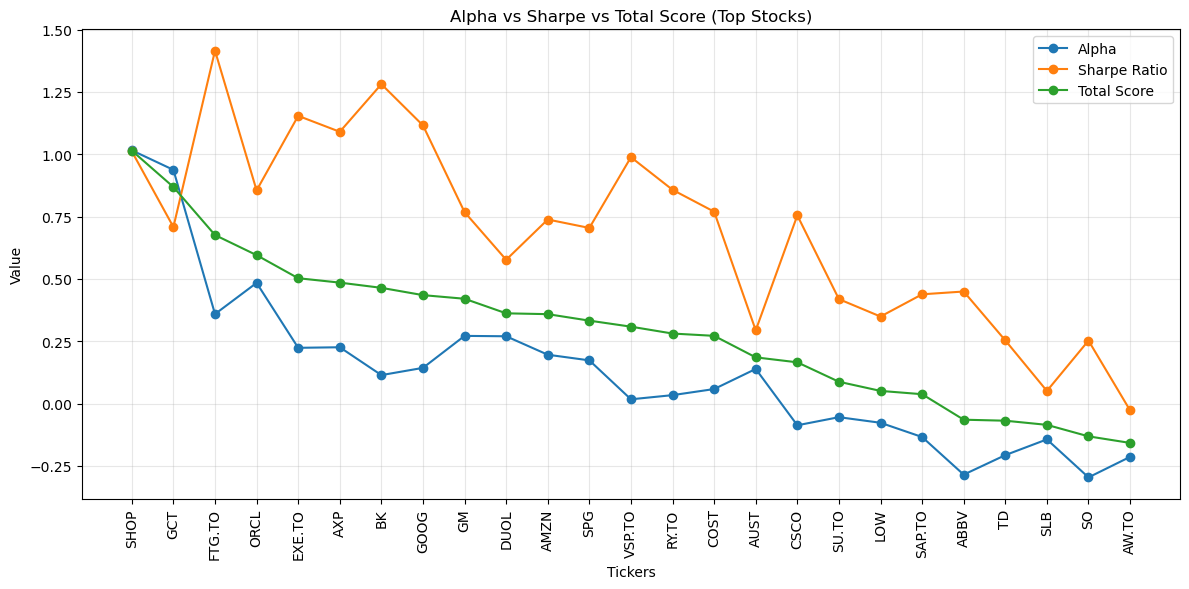

In [7]:
tickers_for_graph = list(top_stocks.keys())
alpha_list = [alpha_values[t] for t in tickers_for_graph]
sharpe_list = [sharpe_ratios[t] for t in tickers_for_graph]
score_list = [total_scores[t] for t in tickers_for_graph]

plt.figure(figsize=(12, 6))
plt.plot(tickers_for_graph, alpha_list, label="Alpha", marker='o')
plt.plot(tickers_for_graph, sharpe_list, label="Sharpe Ratio", marker='o')
plt.plot(tickers_for_graph, score_list, label="Total Score", marker='o')

plt.title("Alpha vs Sharpe vs Total Score (Top Stocks)")
plt.xlabel("Tickers")
plt.ylabel("Value")
plt.xticks(rotation=90)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

We prepare to loop through the top 10, top 11, top 12, etc... until top 25 stocks to see which portfolio gives best returns. This will allow us to decide exactly how many stocks to use.

We begin by creating functions to get the portfolio return and negative portfolio returns, as we use scipy.optimize.minimize. Minimizing the negative of a function will maximize the original function.

## Note: Our portfolio is in terms of CAD.

portfolio_returns(tickers, weights, investment): inputs a list of tickers, weights, and total investment, creates a portfolio, and returns information of the portfolio
- returns the total returns of the portfolio, the portfolio itself, and the number of shares to help track how many fees we should pay

negative_portfolio_returns(weights, tickers, investment): negates portfolio_returns so we can use optimization. The parameters are also swapped to better assist scipy.optimize.minimize as x0 must be the first parameter.
- returns the negative portfolio return

In [8]:
# initialize variables to help with optimization
top_tickers = list(top_stocks.keys())
CAD_INITIAL_INVESTMENT = 1_000_000
stock_shares = {}

# fetches most recent exchange rate (CAD to USD) because we are keeping everything in CAD
EXCHANGE_RATE = yf.download("CADUSD=X", period="1d", auto_adjust=False, progress=False)['Close'].iloc[-1].item()

# calculates the return of a portfolio with fees included
def portfolio_returns(tickers, weights, investment):
    pf = pd.DataFrame()
    total_shares = 0
    # loop through all tickers and keep track of their index
    for index, ticker in enumerate(tickers):
        ticker_currency = ticker_dict[ticker][1] # get the currency of the current ticker
        # ignore currencies at first and simply allocate the required amount in CAD
        allocation = investment*weights[index] # this is in CAD
        # calculate the number of shares by converting its close price to CAD
        first_close = tickers_data[ticker]["Close"].iloc[0]
        # the number of shares we buy is how many we allocate into the ticker divided by its first closing price (in CAD)
        shares = allocation/first_close.item()
        # put the initial investment in the portfolio
        pf[ticker] = shares*tickers_data[ticker]["Close"]
        total_shares += shares

    # create a column for the total value of the portfolio
    pf["Total"] = pf.sum(axis=1)
    # calculate the total returns of the portfolio
    total_returns = (pf["Total"].iloc[-1] - pf["Total"].iloc[0])/(pf["Total"].iloc[0])
    # change returns from a series to a scalar
    total_returns = total_returns.item()
    # return total portfolio returns as first element and the actual portfolio as the second element
    return float(total_returns), pf, total_shares

# maximizing a function is the same as minimizing the negative
def negative_portfolio_returns(weights, tickers, investment):
    return -portfolio_returns(tickers, weights, investment)[0]


Loop through the numbers 10-25 inclusive to decide which portfolio is best (including 10,11,12, ... ,25 stocks)

We also factor in the requirements of 40% or less in one sector through constraints in scipy.

The requirement of a minimum of 100%/2n weighting and a maximum of 15% weighting is also put into play through the bounds method in scipy

scipy.optimize.minimize allows us to mathematically find the optimal weighting of each stock alongside the return. We then display the optimal number of stocks

optimal_stocks: list of the best stocks

optimal_weighting: list of each optimal_stock's weighting

max_number_stock: optimal number of stocks

In [9]:
# dictionary stores all of the best portfolios from choosing 10-25 stocks
all_optimals = {}
# loop through the numbers 10-25 inclusive to create portfolios with 10-25 stocks inclusive
for i in range(10, 26):
    # get the top n stocks (top 10, top 11, ... , top 25)
    top_n_tickers = top_tickers[:i]
    
    # Build sector constraints 
    # Loop through all tickers in the portfolio and get tickers from the start. Used set to remove duplicates
    sectors = set(ticker_dict[t][0] for t in top_n_tickers)
    # List of constraints for stock
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # weights sum to 1
    ]
    # Create constraints per sector
    for sector in sectors:
        tickers_in_sector = [t for t in top_n_tickers if ticker_dict[t][0] == sector]
        # Combined all constraints
        constraints.append(
            # Constaint is an upper bound and not equality so we need to use inequality instead of equality sector <= 40%
            {
                'type': 'ineq',
                'fun': lambda w, tickers_in_sector=tickers_in_sector:
                # Builds list of all weights for stocks in the sector and ensure its less than 40% or else it will fail inequality 
                    0.4 - np.sum([w[top_n_tickers.index(t)] for t in tickers_in_sector])
            }
        )

    # optimizes each respective portfolio with 10 stocks, 11 stocks, etc.
    optimal_n = sp.optimize.minimize(
        fun=negative_portfolio_returns,
        x0=[1/i] * i,
        args=(top_n_tickers, CAD_INITIAL_INVESTMENT),
        method='SLSQP',
        bounds=[(1/(2*i), 0.15)] * i,
        constraints=constraints,
        options={'ftol': 1e-12}
    )
    # add all optimal portfolios to the dictionary with its weightings and its return
    all_optimals[i] = (optimal_n.x, -optimal_n.fun)

# initialize max variables
max_return = 0
max_number_stock = 0
# will get the maximum return portfolio and how many stocks we should choose
for n_stocks in list(all_optimals.keys()):
    # the return of the current portfolio we are looking at
    stock_return = all_optimals[n_stocks][1]
    # check if the current portfolio we are looking at has a greater return than the max
    if stock_return > max_return:
        # if it does, then change the max to the current portfolio
        max_return = stock_return
        max_number_stock = n_stocks

# output max return
optimal_weighting = all_optimals[max_number_stock][0]
optimal_stocks = top_tickers[:max_number_stock]
print(f"Optimal number of stocks:  {max_number_stock}")

sector_weights = {}
for t, w in zip(optimal_stocks, optimal_weighting):
    sector = ticker_dict[t][0]
    sector_weights[sector] = sector_weights.get(sector, 0) + w

# Output overall return percentage of optimal portfolio
print(f"Return of optimal portfolio: {max_return*100:.4f}%")



Optimal number of stocks:  25
Return of optimal portfolio: 70.3436%


Here is a visualization of the Market Cap of each Stock in the optimal portfolio

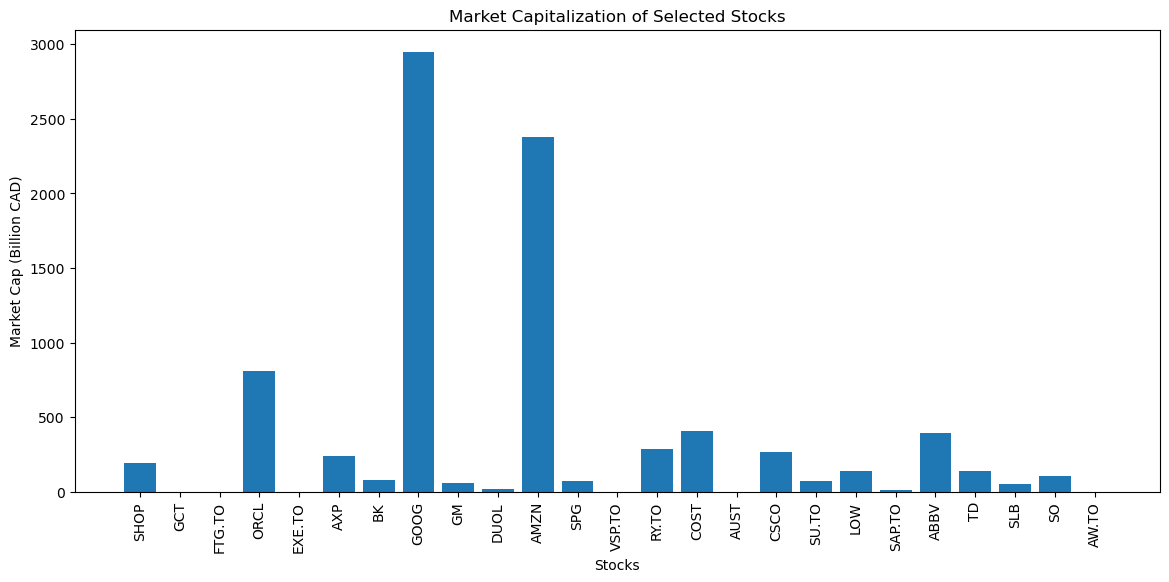

In [10]:
tickers = optimal_stocks

market_caps = [get_market_cap(t) for t in tickers]

market_caps_bil = [mc / 1e9 for mc in market_caps]

plt.figure(figsize=(14, 6))
plt.bar(tickers, market_caps_bil)
plt.xticks(rotation=90)
plt.ylabel("Market Cap (Billion CAD)")
plt.xlabel("Stocks")
plt.title("Market Capitalization of Selected Stocks")
plt.show()

Here is a bar graph illustrating how much weighting is put into each stock for our optimal portfolio

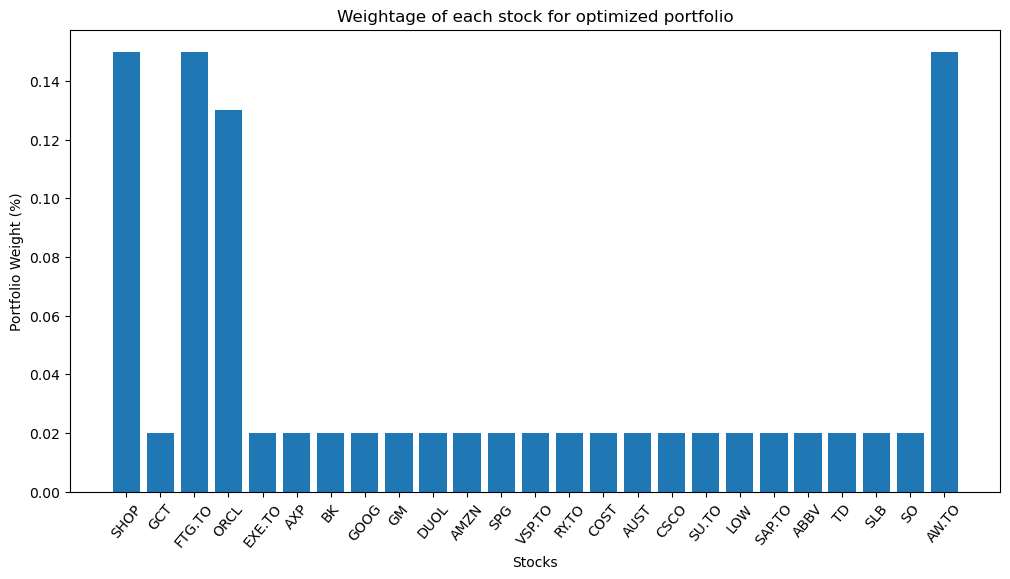

In [11]:
def plot_weight_distribution(tickers, weights):

    plt.figure(figsize=(12, 6))
    plt.bar(tickers, weights)
    plt.xticks(rotation = 50)
    plt.xlabel('Stocks')
    plt.ylabel('Portfolio Weight (%)')
    plt.title('Weightage of each stock for optimized portfolio')
    plt.show()

plot_weight_distribution(optimal_stocks, optimal_weighting)

Here is a pie-chart illustrating how much we have in each sector to illustrate how we have met sector restrictions.

Industry Breakdown (by portfolio weight):
Technology: 34.00%
Industrials: 15.00%
Healthcare: 4.00%
Financial Services: 8.00%
Communication Services: 2.00%
Consumer Cyclical: 21.00%
Real Estate: 2.00%
None: 2.00%
Consumer Defensive: 4.00%
Basic Materials: 2.00%
Energy: 4.00%
Utilities: 2.00%


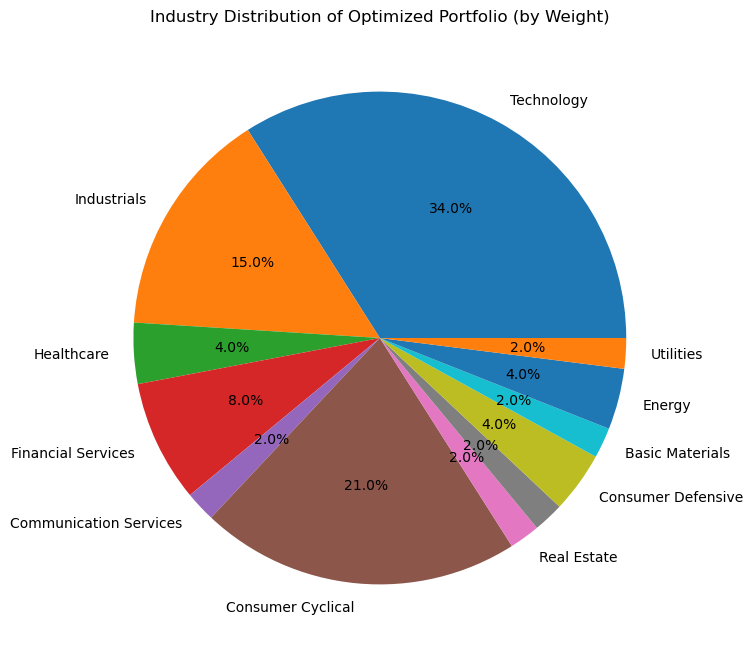

In [12]:
def plot_industry_distribution(tickers, ticker_dict, weights):
    # Map tickers to weights for easy lookup
    w_by_ticker = dict(zip(tickers, weights))

    # Aggregate weights by sector
    sector_weights = {}
    for t in tickers:
        sector = ticker_dict[t][0]  # sector is stored here
        sector_weights[sector] = sector_weights.get(sector, 0) + w_by_ticker[t]

    # Print the weights 
    print("Industry Breakdown (by portfolio weight):")
    for sector, w in sector_weights.items():
        print(f"{sector}: {w*100:.2f}%")

    # Build pie chart
    labels = list(sector_weights.keys())
    sizes = [w * 100 for w in sector_weights.values()]  # convert to percentages

    plt.figure(figsize=(8, 8))
    plt.pie(
        sizes,
        labels=labels,
        autopct="%1.1f%%",
    )
    plt.title("Industry Distribution of Optimized Portfolio (by Weight)")
    plt.show()

plot_industry_distribution(optimal_stocks, ticker_dict, optimal_weighting)



Below is the code we use to generate our final portfolio for submission.

First we create a portfolio with the optimal_stocks and optimal_weighting. We note that the optimal_stocks and optimal_weightings are aligned, so the indexes match up. This means the first of optimal_stocks corresponds to the first of optimal_weighting, the second of optimal_stocks corresponds to the second of optimal_weighting, and etc.

We then calculate how much we can actually invest by deducting fees, the minimum of $\$2.15$ USD and $\$0.001$ USD per share.

### We also note that our portfolio is in terms of CAD.

We then get the last closing price of each stock to complete our final portfolio for submission.

get_last_close(tickers): inputs a list of tickers and finds the last closing price for each ticker
- returns a dictionary mapping each ticker to its last closing price

generate_final_pf(tickers, weights, investment): inputs a list of tickers, weights, and investment to create a final portfolio for submission
- returns a DataFrame: Index 1…n; columns: Ticker, Price, Currency, Shares, Value, Weight.
- Note, Shares is calculated in terms of CAD since our portfolio is in terms of CAD.

In [13]:
# store the data so we can find the number of shares without fees deducted
optimal_portfolio_data = portfolio_returns(optimal_stocks, optimal_weighting, CAD_INITIAL_INVESTMENT)
optimal_portfolio_num_shares = optimal_portfolio_data[2]
# Divide by Exchange Rate to get from USD to CAD as our entire portfolio is in terms of CAD
fees = min(2.15/EXCHANGE_RATE, (0.001/EXCHANGE_RATE)*optimal_portfolio_num_shares)
# find how much we actually have in our portfolio after fees
actual_portfolio_investment = CAD_INITIAL_INVESTMENT - fees
actual_portfolio_investment

final_pf_data = {}

def get_last_close(tickers):
    last_closing_prices = {}
    for ticker in tickers:
        ticker_close = yf.download(ticker, period="1d", auto_adjust=False, progress=False)["Close"].iloc[0].item()
        last_closing_prices[ticker] = ticker_close

    return last_closing_prices

last_closing_prices = get_last_close(optimal_stocks)

# - Portfolio_Final DataFrame: Index 1…n; columns: Ticker, Price, Currency, Shares, Value, Weight.
def generate_final_pf(tickers, weights, investment):
    weights_dict = dict(zip(tickers, weights))
    prices = list(last_closing_prices.values())
    currencies = [ticker_dict[ticker][1] for ticker in tickers]
    shares = []
    for ticker in tickers:
        ticker_currency = ticker_dict[ticker][1]
        if ticker_currency == "USD":
            # convert USD to CAD
            ticker_shares = investment*weights_dict[ticker]/(last_closing_prices[ticker]/EXCHANGE_RATE)
        else:
            ticker_shares = investment*weights_dict[ticker]/(last_closing_prices[ticker]/EXCHANGE_RATE)
        shares.append(ticker_shares)
    values = [investment*weights_dict[ticker] for ticker in tickers]
    pf_dict = {
        "Ticker" : tickers,
        "Price" : prices,
        "Currency" : currencies,
        "Shares" : shares,
        "Value" : values,
        "Weight" : weights*100,
    }
    final_pf = pd.DataFrame(pf_dict)
    final_pf.index += 1
    return final_pf

final_pf = generate_final_pf(optimal_stocks, optimal_weighting, actual_portfolio_investment)
final_pf
    

,Ticker,Price,Currency,Shares,Value,Weight
1,SHOP,159.339996,USD,671.263806,149999.547726,15.0
2,GCT,37.320000,USD,382.133524,19999.939697,2.0
3,FTG.TO,11.120000,CAD,9618.630715,149999.547726,15.0
4,ORCL,204.960007,USD,452.273353,129999.608029,13.0
5,EXE.TO,20.990000,CAD,679.429402,19999.939697,2.0
6,AXP,363.970001,USD,39.182413,19999.939697,2.0
7,BK,111.389999,USD,128.029653,19999.939697,2.0
8,GOOG,320.279999,USD,44.527361,19999.939697,2.0
9,GM,72.809998,USD,195.869022,19999.939697,2.0
10,DUOL,188.429993,USD,75.684464,19999.939697,2.0


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.
- Richard Meng
- Avaansh Nanda
- Devesh Kotak